In [248]:
import polars as pl
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.express as px

#load dataframe
df = pl.read_csv("data/final_all_features_and_metrics.csv")

#preprocess columns to be used in the model
df = df.to_pandas() #convert to pandas dataframe
df.drop(columns = df.loc[:, "channel_id" : "description"].columns, axis = 1, inplace=True) #drop columns that are not needed
df.drop("tags", axis = 1, inplace=True) #drop tags column


columns_to_standardize = ['subjectivity', 'duration', 'channel_activity', 'capitalisation_ratio'] #define columns to standardize
scaler = StandardScaler() #initialize standard scaler
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize]) #standardize columns

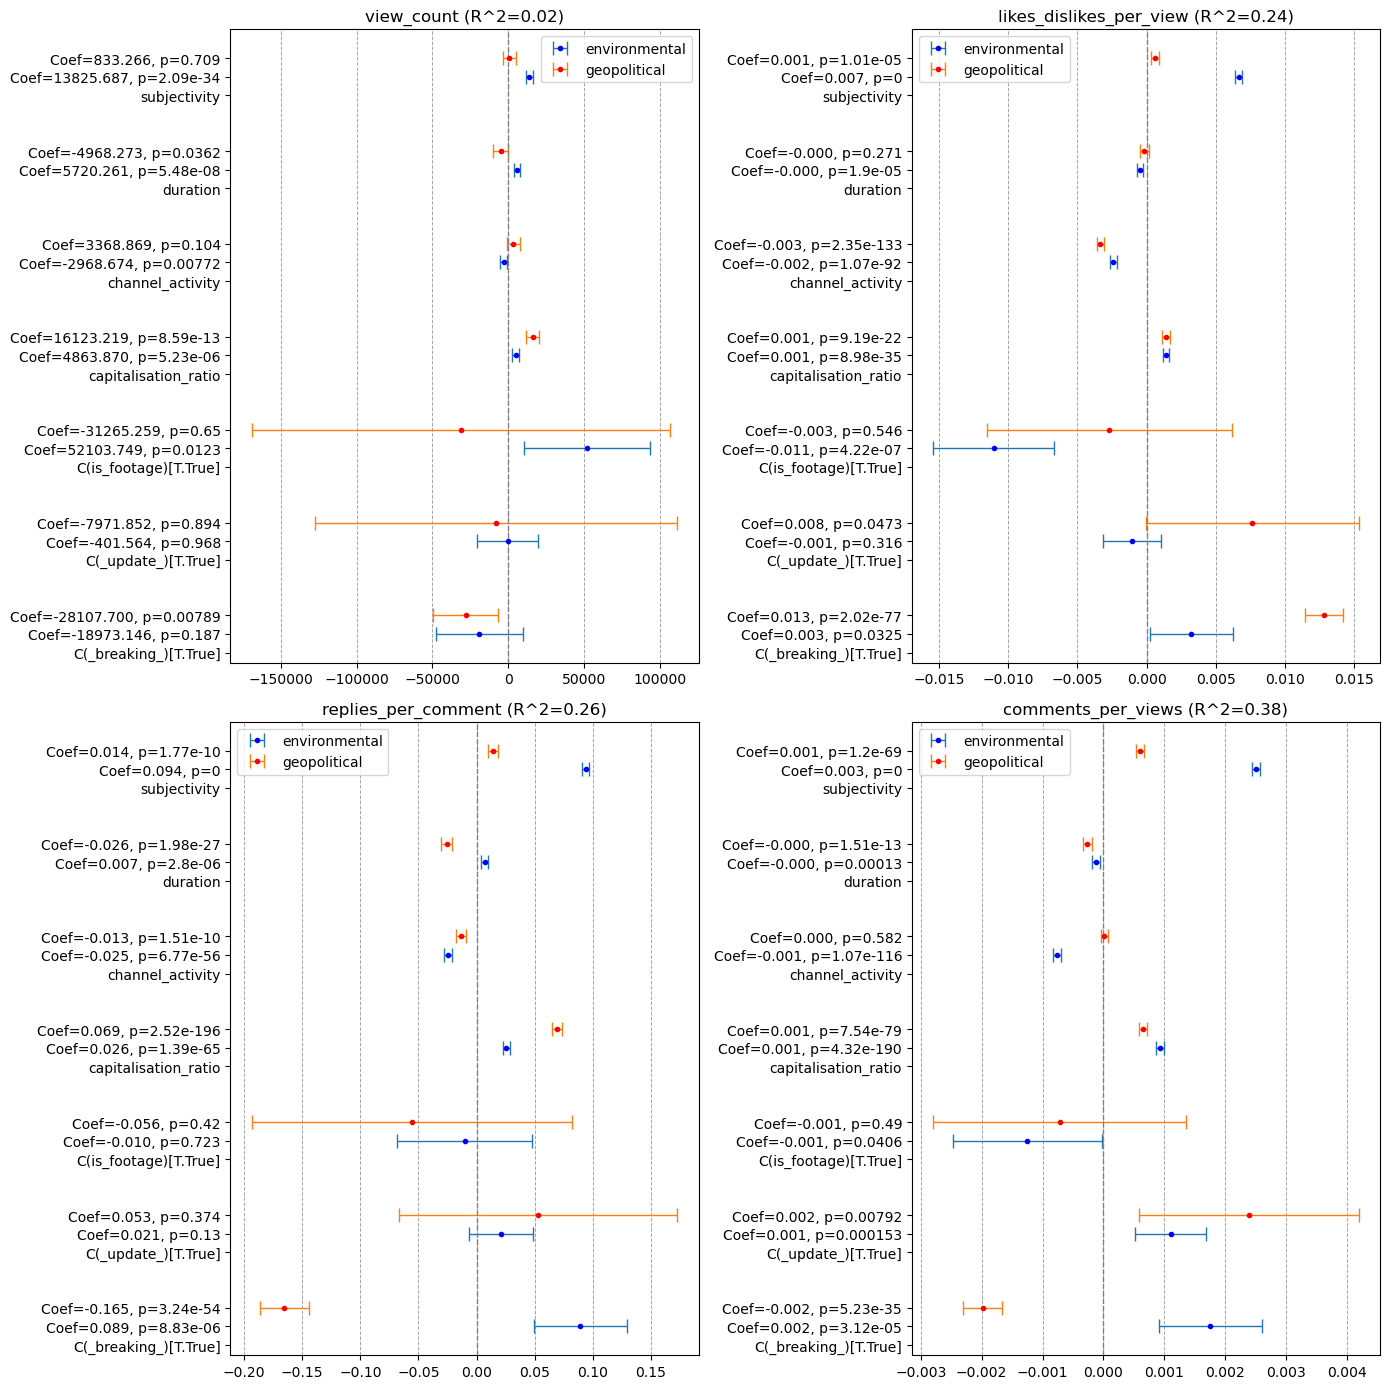

In [249]:
#rename columns
df.rename(columns={
    'likes-dislikes/views': 'likes_dislikes_per_view',
    'replies/comment': 'replies_per_comment',
    'likes/comment': 'likes_per_comment'
}, inplace=True)

# add the comments per view metric
df['comments_per_views'] = df['num_comments'] / df['view_count']


# Define the dependent variables and the independent variables
# Create a list in order to iterate over them
dependent_vars = [
    'view_count', 
    'likes_dislikes_per_view', 
    'replies_per_comment', 
    'comments_per_views'
]

independent_formula_part = (
    "subjectivity + duration + channel_activity + capitalisation_ratio + "
    "C(is_footage) + C(_breaking_) + C(_update_)"
)

#fix random seed
np.random.seed(2)

# Create a figure to plot the results
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
axs = axs.ravel()  # Flatten to iterate easily

colors = {'environmental': 'blue', 'geopolitical': 'red'} # Define colors for each event type

for i, dv in enumerate(dependent_vars):
    ax = axs[i]

    y_labels = []
    y_positions = []
    position_offset = 0

    max_r2 = 0  # Track maximum R^2 for the current dependent variable

    for j, (event_type, color) in enumerate(colors.items()):\

        filtered_df = df[df['event_type'] == event_type]
        
        formula = f"{dv} ~ {independent_formula_part}"
        mod = smf.ols(formula=formula, data=filtered_df) 
        res = mod.fit()

        r2 = res.rsquared
        max_r2 = max(max_r2, r2)

        variables = res.params.index
        coefficients = res.params.values
        p_values = res.pvalues.values
        standard_errors = res.bse.values

        sorted_results = sorted(
            zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:]), 
            key=lambda x: x[1]
        )
        l1, l2, l3, l4 = zip(*sorted_results)

        event_positions = np.arange(len(l1)) + position_offset
        position_offset += 0.2

        for idx, (v, coef, pv) in enumerate(zip(l2, l1, l4)):
            if j == 0:  # Add variable name only once
                y_labels.append(f"{v}")
                y_positions.append(event_positions[idx] - 0.2)
            y_labels.append(f"Coef={coef:.3f}, p={pv:.3g}")
            y_positions.append(event_positions[idx])

        # Plot coefficients with error bars (2*std_err for 95% CI)
        ax.errorbar(l1, event_positions, xerr=2*np.array(l3),
                    linewidth=1, linestyle='none', marker='o', markersize=3,
                    markerfacecolor=color, markeredgecolor=color, capsize=5, label=f'{event_type}')
    

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, ha='right', color='black')

    # Add zero reference line and set titles
    ax.axvline(x=0, linestyle='--', color='grey', linewidth=1)
    ax.set_title(f"{dv} (R^2={max_r2:.2f})", fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.xaxis.grid(True, linestyle='--', color='gray', linewidth=0.7, alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

In [290]:
from plotly.subplots import *
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=2, subplot_titles=dependent_vars, horizontal_spacing=0.3, vertical_spacing=0.15)
colors = {'environmental': 'blue', 'geopolitical': 'red'} # Define colors for each event type

for i, dv in enumerate(dependent_vars):
    ax = axs[i]

    y_labels = []
    y_positions = []
    position_offset = 0

    max_r2 = 0  # Track maximum R^2 for the current dependent variable

    for j, (event_type, color) in enumerate(colors.items()):\

        filtered_df = df[df['event_type'] == event_type]
        
        formula = f"{dv} ~ {independent_formula_part}"
        mod = smf.ols(formula=formula, data=filtered_df) 
        res = mod.fit()

        r2 = res.rsquared
        max_r2 = max(max_r2, r2)

        variables = res.params.index
        coefficients = res.params.values
        p_values = res.pvalues.values
        standard_errors = res.bse.values

        sorted_results = sorted(
            zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:]), 
            key=lambda x: x[1]
        )
        l1, l2, l3, l4 = zip(*sorted_results)

        event_positions = np.arange(len(l1)) + position_offset
        position_offset += 0.2

        for idx, (v, coef, pv) in enumerate(zip(l2, l1, l4)):
            if j == 0:  # Add variable name only once
                y_labels.append(f"{v}")
                y_positions.append(event_positions[idx] - 0.2)
            y_labels.append(f"Coef={coef:.3f}, p={pv:.3g}")
            y_positions.append(event_positions[idx])
        
        show_legend = True
        if i > 0:
            show_legend = False
        # Plot coefficients with error bars (2*std_err for 95% CI)
        fig.add_trace(go.Scatter(x = l1,y = event_positions,error_x=dict(type='data', array=2*np.array(l3), visible=True), 
                                 mode='markers', marker=dict(color=color), name = event_type, 
                                 showlegend = show_legend, text = l2), row = i//2+1, col = i%2 + 1)         
        
        fig.update_traces(hovertemplate = 'Variable: %{text[0]} <br> Correlation Coefficient: %{x} <br> p-value: %{text[1]:.5f}<extra></extra>', row = i//2+1, col = i%2+1, text=np.stack((l2, l4), axis=-1),
                          )
        
        fig.update_yaxes(title_text='Variable', row=i//2+1, col=i%2+1, tickvals = event_positions, ticktext = l2)
        fig.update_xaxes(title_text='Correlation Coefficient', row=i//2+1, col=i%2+1)
    

fig.update_layout(title_text='Regression Analysis of Features and Metrics',
                    title_x=0.5,
                    height=1000,
                    width=1000)


fig.show()
        